# Example: Slope restricted nonlinearity
## Setup

In [1]:
import numpy as np
import scipy.linalg as la
import mosek
import mosek.fusion as fusion
import matplotlib.pyplot as plt
import matplotlib
import cvxpy as cp
import itertools

matplotlib.rcParams['pdf.fonttype'] = 42

To ensure reproducability, we set a seed for the random number generation.

In [2]:
np.random.seed(12345)

## Introducing the example
**TODO**

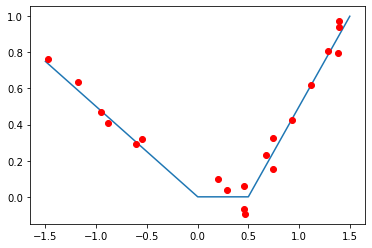

In [3]:
x_low = -1.5
x_high = 1.5
b_noise_true = 0.1
b_noise = b_noise_true
n_samples = 20

slope_lower = -1
slope_upper = 2

xs = np.linspace(x_low, x_high, 1000)

def f_target(x):
    return np.piecewise(x, [x<0, x >= 0, x >= 0.5], [lambda x: -0.5*x, 0, lambda x: x-0.5])

ys = f_target(xs)

xs_train = np.sort(np.random.uniform(low=x_low, high=x_high, size=n_samples))
ys_train = f_target(xs_train) + np.random.uniform(low=-b_noise_true, high=b_noise_true, size=n_samples)

plt.plot(xs,ys)
plt.plot(xs_train, ys_train, 'ro')

## Nominal predictor: Running the Hard Shape Constrained Kernel Machine
**Kernel choice** We use the squared exponential kernel with length scale $\ell$, 
$$k(x,x')=\psi(x-x')=\exp(-(x-x')^2/2\ell^2).$$
In the following, we use $\ell=0.5$.

In [4]:
ell = 0.5

_Remark_ In practice, this hyperparameter can and should be tuned (as well as the choice of kernel). However, the guarantees (properties and containment of nominal prediction, uncertainty sets and overapproximation of uncertainty set) are not affected by this (worst case is infeasibility of the convex optimization problem).

**Setup for tightening** Next, we set up the grid for the tightening.

In [5]:
n_grid = 200
xs_grid = np.linspace(x_low,x_high,n_grid)
delta = xs_grid[1]-xs_grid[0]

For the actual tightening, we need the parameter $\eta$.
First, let's collect the derivatives of the squared exponential kernel function.

In [6]:
def psi0(x):
    return np.exp(-x**2/(2*ell**2))

def psi1(x):
    return -1/(ell**2)*x*np.exp(-x**2/(2*ell**2))
    
def psi2(x):
    return (-1/(ell**2) + x**2/(ell**4))*np.exp(-x**2/(2*ell**2))

We now use the gridding procedure from https://github.com/PCAubin/Hard-Shape-Constraints-for-Kernels/blob/main/code/ToyQuadratic_MonotonousLeastSquares.m  
Since the SE kernel is a radial kernel, hence also a translation-invariant, it is enough to find the maximum of $\sqrt{|2\psi^{\prime\prime}(0)-2\psi^{\prime\prime}(x)|}$ for $x\in[0,\delta]$.

In [7]:
xs_local = np.linspace(0, delta, 1000)
psi1_local = psi1(xs_local)
delta_max = xs_local[np.argmin(psi1_local[1:]-psi1_local[:-1]<0)]

eta = np.max(np.sqrt(np.abs(2*psi2(0)-2*psi2(xs_local))))

In [8]:
eta

0.10442549634825546

**Optimization problem** We can now build the finite-dimensional SOC problem.
First, let's build the kernel matrix. As usual, we add some regularization to improve numerical stability.
Note also the minus signs arising from $k(x,x')=\psi(x-x')$.

In [9]:
# Kernel matrix setup
# Blocks
# 0    Data
# 1    Geometric constraints, here the slopes (note that we reuse the grid)
# 2    Pointwise constraint
K00 = psi0(xs_train.reshape([-1,1])-xs_train.reshape([1,-1]))
K01 = -psi1(xs_train.reshape([-1,1])-xs_grid.reshape([1,-1]))
K11 = -psi2(xs_grid.reshape([-1,1])-xs_grid.reshape([1,-1]))
K02 = psi0(xs_train.reshape([-1,1])-0)
K21 = -psi1(0-xs_grid.reshape([1,-1]))
K22 = psi0(0)
K = np.block([
    [K00   , K01, K02],
    [K01.T, K11, K21.T],
    [K02.T, K21, K22]
])
K0 = np.block([K00, K01, K02])
K1 = np.block([K01.T, K11, K21.T])
K2 = np.block([K02.T, K21, K22])


K_reg = K + 10e-4*np.identity(n_samples+n_grid+1)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_samples+n_grid+1)

Next, we construct the actual optimization problem using the MOSEK Fusion API.

In [10]:
# Optimization problem
M = fusion.Model()

# Variables
n_coeffs = n_samples + n_grid + 1

## Coefficients arising from the RT
alphas = M.variable("alphas", n_coeffs, fusion.Domain.unbounded())

# Data constraints
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas), ys_train), fusion.Domain.lessThan(b_noise))
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas), ys_train), fusion.Domain.greaterThan(-b_noise))

# Geometric constraints
## Introduce the expression $K^{\frac{1}{2}}\alpha$ as a variable
x_norm = M.variable("x_norm", n_coeffs, fusion.Domain.unbounded())
M.constraint(fusion.Expr.sub(x_norm, fusion.Expr.mul(K_sqrt, alphas)), fusion.Domain.equalsTo(0.0))

## Use MOSEK Fusion vectorization
## Lower bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(1/eta*K1, alphas), 1/eta*slope_lower), 
        fusion.Var.hrepeat(x_norm, n_grid).transpose()), 
    fusion.Domain.inQCone())

## Upper bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(-1/eta*K1, alphas), -1/eta*slope_upper), 
        fusion.Var.hrepeat(x_norm, n_grid).transpose()), 
    fusion.Domain.inQCone())

# Pointwise constraint
M.constraint(fusion.Expr.mul(K2, alphas), fusion.Domain.equalsTo(0.))

# Objective function
c_reg = 100

## Quadratic part (incl RKHS norm) via SOC
Q = K0.T @ K0 + c_reg*K
U,s_vals, Vh = la.svd(Q)
Q_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_coeffs)

t_quad = M.variable("t_quad", 1, fusion.Domain.unbounded())
M.constraint(fusion.Expr.vstack(t_quad, 1, fusion.Expr.mul(Q_sqrt, alphas)), fusion.Domain.inRotatedQCone())

## Linear part
c_vec = -2*K0.T @ ys_train

## Full objective
M.objective(fusion.ObjectiveSense.Minimize, fusion.Expr.add(t_quad, fusion.Expr.dot(c_vec, alphas)))

# Run the optimization problem
M.solve()
print(M.getProblemStatus())

ProblemStatus.PrimalAndDualFeasible


Inspect the result.

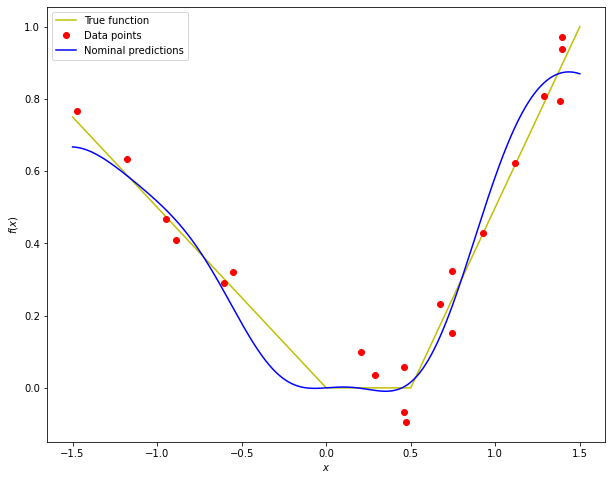

In [11]:
alphas_val = M.getVariable("alphas").level()
ys_pred = np.block([
    psi0(xs.reshape([-1,1]) - xs_train.reshape([1,-1])),
    -psi1(xs.reshape([-1,1]) - xs_grid.reshape([1,-1])),
    psi0(xs.reshape([-1,1])-0)
]) @ alphas_val

plt.figure(figsize=(10,8))
plt.plot(xs, ys, '-y')
plt.plot(xs_train, ys_train, 'ro')
plt.plot(xs, ys_pred, 'b-')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(["True function", "Data points", "Nominal predictions"])

Sanity check: Slope via finite differences

Text(0, 0.5, 'Finite differences of $\\hat f$')

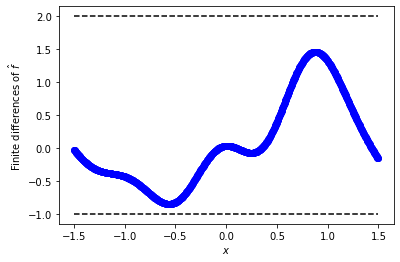

In [12]:
fds = (ys_pred[1:]-ys_pred[:-1])/(xs[1:]-xs[:-1])
plt.plot(xs[:-1], fds, 'bo')
plt.plot(xs, np.full_like(xs,slope_upper), 'k--')
plt.plot(xs, np.full_like(xs,slope_lower), 'k--')
plt.xlabel('$x$')
plt.ylabel('Finite differences of $\hat f$')

Sanity check: Value at 0

In [13]:
print(np.block([
    psi0(0- xs_train.reshape([1,-1])),
    -psi1(0 - xs_grid.reshape([1,-1])),
    psi0(0-0)
]) @ alphas_val)

[1.48880745e-10]


## Uncertainty sets
### Standard uncertainty set
We now construct the traditional uncertainty sets for Lipschitz continuous functions (with known upper bound on the Lipschitz constant) and bounded noise.

In [14]:
def ub(x):
    return np.min([
        np.min(np.where(
            x >= xs_train, 
            ys_train + b_noise + slope_upper*(x-xs_train), 
            ys_train + b_noise + slope_lower*(x-xs_train))),
        slope_upper*x if x >= 0 else slope_lower*x
    ])

def lb(x):
    return np.max([
        np.max(np.where(
            x >= xs_train, 
            ys_train - b_noise + slope_lower*(x-xs_train), 
            ys_train - b_noise + slope_upper*(x-xs_train))),
        slope_lower*x if x >= 0 else slope_upper*x
    ])

ubs = np.array([ub(x) for x in xs])
lbs = np.array([lb(x) for x in xs])

Plot the prediction.

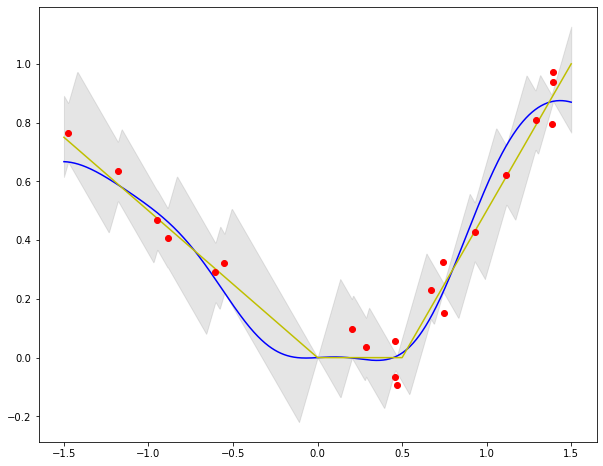

In [15]:
plt.figure(figsize=(10,8))
plt.plot(xs, ys_pred, 'b-')
plt.plot(xs, ys, '-y')
plt.plot(xs_train, ys_train, 'ro')

plt.fill_between(xs, [lb(x) for x in xs], [ub(x) for x in xs], color='gray', alpha=0.2)

Sanity check: Is our nominal prediction contained in the standard uncertainty set?

In [16]:
print(f"Largest upper bound violation: {np.max(np.hstack([ys_pred-ubs, np.zeros_like(ys_pred)]))}")
print(f"Largest lower bound violation: {np.min(np.hstack([ys_pred-lbs, np.zeros_like(ys_pred)]))}")

Largest upper bound violation: 0.0
Largest lower bound violation: 0.0


### Smoothed uncertainty set

In [17]:
# Get eta
# We use the approach from https://github.com/PCAubin/Hard-Shape-Constraints-for-Kernels/blob/main/code/ToyQuadratic_MonotonousLeastSquares.m
xs_local = np.linspace(0, 10*ell, 1000)
psi1_local = psi1(xs_local)
delta_max = xs_local[np.argmin(psi1_local[1:]-psi1_local[:-1]<0)]

# Virtual points (grid used for SOC)
n_grid = 200
xs_grid = np.linspace(x_low,x_high,n_grid)
delta = xs_grid[1]-xs_grid[0]
eta = np.sqrt(2*psi0(0)-2*psi0(delta))
#eta = 0.1

#lambda_obj = cp.Variable()
#lambda_ub = cp.Variable()

K = psi0(xs_grid.reshape([-1,1])-xs_grid.reshape([1,-1]))
K_reg = K + 10e-4*np.identity(n_grid)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_grid)

ub_grid = np.array([ub(x) for x in xs_grid])

Since this optimization problem is much easier, we use the more convenient cvxpy interface to MOSEK.

In [18]:
beta = cp.Variable([n_grid,1])
constraints_ub = [cp.SOC(K[i,:] @ beta - ub_grid[i], eta*K_sqrt @ beta) for i in range(n_grid)]
#constraints_cumulative = [cp.quad_form(beta, K_reg) <= lambda_obj]
#constraints_obj = [cp.sum(K_reg @ beta - ub_grid.reshape([-1,1])) <= lambda_ub]

prob = cp.Problem(
    cp.Minimize(cp.sum(K_reg @ beta - ub_grid.reshape([-1,1]))),
    constraints_ub
)
prob.solve()
beta_ub = beta.value

lb_grid = np.array([lb(x) for x in xs_grid])
constraints_lb = [cp.SOC(-K[i,:] @ beta + lb_grid[i], eta*K_sqrt @ beta) for i in range(n_grid)]

prob = cp.Problem(
    cp.Minimize(cp.sum(lb_grid.reshape([-1,1]) - K_reg @ beta )),
    constraints_lb
)
prob.solve(solver=cp.MOSEK)
beta_lb = beta.value

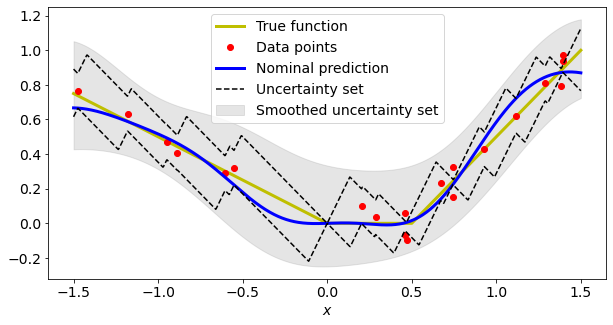

In [19]:
K_plot = psi0(xs.reshape([-1,1])-xs_grid.reshape([1,-1]))
plt.figure(figsize=(10,5))
matplotlib.rcParams.update({'font.size': 14})

plt.plot(xs, ys, 'y', label="True function", linewidth=3)
plt.plot(xs_train, ys_train, 'ro', label="Data points")
plt.plot(xs, ys_pred, 'b-', label="Nominal prediction", linewidth=3)
plt.plot(xs, [ub(x) for x in xs], 'k--', label= "Uncertainty set")
plt.plot(xs, [lb(x) for x in xs], 'k--')
plt.fill_between(xs, (K_plot@beta_lb).flatten(), (K_plot@beta_ub).flatten(), color='gray', alpha=0.2,label= "Smoothed uncertainty set")

plt.xlabel("$x$")
plt.legend()
plt.savefig('output/example_sloperestricted.pdf', bbox_inches="tight")

## Backups

In [20]:
# Kernel matrix setup
# Blocks
# 0    Data
# 1    Geometric constraints, here the slopes (note that we reuse the grid)
# 2    Pointwise constraint
K00 = psi0(xs_train.reshape([-1,1])-xs_train.reshape([1,-1]))
K01 = -psi1(xs_train.reshape([-1,1])-xs_grid.reshape([1,-1]))
K11 = -psi2(xs_grid.reshape([-1,1])-xs_grid.reshape([1,-1]))
K = np.block([
    [K00   , K01],
    [K01.T, K11]
])
K0 = np.block([K00, K01])
K1 = np.block([K01.T, K11])

K_reg = K + 10e-4*np.identity(n_samples+n_grid)

U,s_vals, Vh = la.svd(K)
K_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_samples+n_grid)

In [21]:
# Optimization problem
M = fusion.Model()

# Variables
n_coeffs = n_samples + n_grid

## Coefficients arising from the RT
alphas = M.variable("alphas", n_coeffs, fusion.Domain.unbounded())

# Data constraints
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas), ys_train), fusion.Domain.lessThan(b_noise))
M.constraint(fusion.Expr.sub(fusion.Expr.mul(K0, alphas), ys_train), fusion.Domain.greaterThan(-b_noise))

# Geometric constraints
## Introduce the expression $K^{\frac{1}{2}}\alpha$ as a variable
x_norm = M.variable("x_norm", n_coeffs, fusion.Domain.unbounded())
M.constraint(fusion.Expr.sub(x_norm, fusion.Expr.mul(K_sqrt, alphas)), fusion.Domain.equalsTo(0.0))

## Use MOSEK Fusion vectorization
## Lower bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(1/eta*K1, alphas), 1/eta*slope_lower), 
        fusion.Var.hrepeat(x_norm, n_grid).transpose()), 
    fusion.Domain.inQCone())

## Upper bound on slope
M.constraint(fusion.Expr.hstack(
        fusion.Expr.sub(fusion.Expr.mul(-1/eta*K1, alphas), -1/eta*slope_upper), 
        fusion.Var.hrepeat(x_norm, n_grid).transpose()), 
    fusion.Domain.inQCone())

# Objective function
c_reg = 100

## Quadratic part (incl RKHS norm) via SOC
Q = K0.T @ K0 + c_reg*K
U,s_vals, Vh = la.svd(Q)
Q_sqrt = U @ np.diag(np.sqrt(s_vals)) @ Vh + 10e-4*np.identity(n_coeffs)

t_quad = M.variable("t_quad", 1, fusion.Domain.unbounded())
M.constraint(fusion.Expr.vstack(t_quad, 1, fusion.Expr.mul(Q_sqrt, alphas)), fusion.Domain.inRotatedQCone())

## Linear part
c_vec = -2*K0.T @ ys_train

## Full objective
M.objective(fusion.ObjectiveSense.Minimize, fusion.Expr.add(t_quad, fusion.Expr.dot(c_vec, alphas)))

# Run the optimization problem
M.solve()
print(M.getProblemStatus())

ProblemStatus.PrimalAndDualFeasible


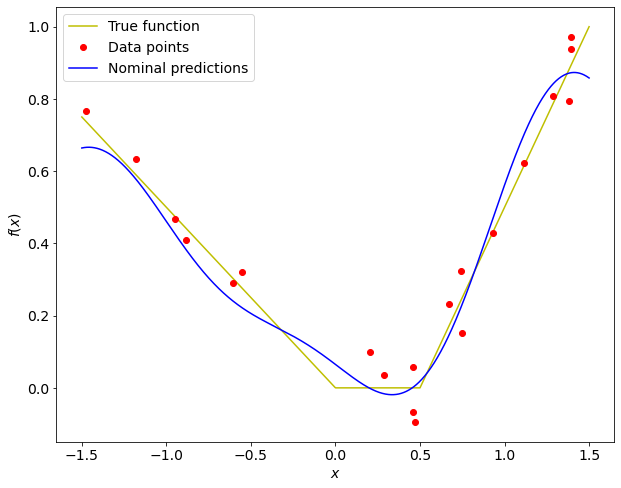

In [22]:
alphas_val = M.getVariable("alphas").level()
ys_pred = np.block([
    psi0(xs.reshape([-1,1]) - xs_train.reshape([1,-1])),
    -psi1(xs.reshape([-1,1]) - xs_grid.reshape([1,-1]))
]) @ alphas_val

plt.figure(figsize=(10,8))
plt.plot(xs, ys, '-y')
plt.plot(xs_train, ys_train, 'ro')
plt.plot(xs, ys_pred, 'b-')

plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.legend(["True function", "Data points", "Nominal predictions"])